# Implementación del modelo base

### José Daniel Gómez Cabrera 21429

- Entrenar un modelo inicial con LightGBM utilizando métricas tradicionales como AUC-ROC y F1-score.
- Evaluar el rendimiento inicial en términos de fraude detectado y falsos positivos.


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

In [16]:
df = pd.read_csv('../data/dataset_feature_engineering.csv', header=0)

In [17]:
df.head()

,cc_num,merchant,category,amt,first,last,gender,street,city,state,...,first_time_at_merchant,dist_between_client_and_merch,trans_month,trans_day,hour,year,times_shopped_at_merchant,times_shopped_at_merchant_year,times_shopped_at_merchant_month,times_shopped_at_merchant_day
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,...,True,78.773821,1,1,0,2019,5,4,2,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,...,True,30.216618,1,1,0,2019,4,4,1,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,...,True,108.102912,1,1,0,2019,4,3,1,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,...,True,95.685115,1,1,0,2019,1,1,1,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,...,True,77.702395,1,1,0,2019,6,1,1,1


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 35 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   cc_num                           int64  
 1   merchant                         object 
 2   category                         object 
 3   amt                              float64
 4   first                            object 
 5   last                             object 
 6   gender                           object 
 7   street                           object 
 8   city                             object 
 9   state                            object 
 10  zip                              int64  
 11  lat                              float64
 12  long                             float64
 13  city_pop                         int64  
 14  job                              object 
 15  dob                              object 
 16  trans_num                        object 
 17  unix_tim

## Años y meses disponibles


In [19]:
print("Años disponibles:", df['year'].unique())
print("Meses disponibles:", df['trans_month'].unique())

Años disponibles: [2019 2020]
Meses disponibles: [ 1  2  3  4  5  6  7  8  9 10 11 12]


## Variable objetivo


In [20]:
fraud_dist = df['is_fraud'].value_counts().rename({0: 'No fraud', 1: 'Fraud'})
fraud_percent = (fraud_dist / fraud_dist.sum()) * 100

fraud_df = pd.DataFrame({
    'Amount': fraud_dist,
    'Percentage': fraud_percent.round(2)
})
fraud_df

,Amount,Percentage
is_fraud,,
No fraud,1842743,99.48
Fraud,9651,0.52


## Modelo


In [ ]:
# Modelo 1 - Optimizado para maximizar el monto salvado en fraudes
# Este modelo utiliza LightGBM con una métrica personalizada que considera el monto de las transacciones

# Definimos una métrica personalizada que considera el monto de las transacciones
def amount_saved_metric(y_true, y_pred, amounts):
    """
    Calcula el monto total salvado basado en detecciones correctas de fraude
    y penaliza los falsos positivos que podrían afectar la experiencia del cliente
    
    Args:
        y_true: Etiquetas reales
        y_pred: Predicciones (probabilidades)
        amounts: Montos de las transacciones
    """
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Verdaderos positivos (fraudes detectados correctamente)
    tp_mask = (y_true == 1) & (y_pred_binary == 1)
    amount_saved = amounts[tp_mask].sum()
    
    # Falsos positivos (transacciones legítimas marcadas como fraude)
    fp_mask = (y_true == 0) & (y_pred_binary == 1)
    false_positive_penalty = amounts[fp_mask].sum() * 0.1  # Penalización del 10% por falsos positivos
    
    return amount_saved - false_positive_penalty

# Preparación de datos
# Mantenemos la columna 'amt' para nuestra métrica personalizada
X = df.drop(['is_fraud', 'cc_num', 'merchant', 'category', 'first', 'last', 'gender', 
             'street', 'city', 'state', 'zip', 'job', 'dob', 'trans_num', 'unix_time'], axis=1)
y = df['is_fraud']

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Guardamos los montos para nuestra métrica
train_amounts = X_train['amt'].values
test_amounts = X_test['amt'].values

# Optimización de hiperparámetros usando Optuna
import optuna

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases
    }
    
    # Entrenamiento con validación temprana
    train_data = lgb.Dataset(X_train, y_train)
    valid_data = lgb.Dataset(X_test, y_test)
    
    model = lgb.train(params,
                     train_data,
                     num_boost_round=1000,
                     valid_sets=[valid_data],
                     callbacks=[lgb.early_stopping(stopping_rounds=20)])
    
    # Predicciones
    y_pred = model.predict(X_test)
    
    # Calculamos nuestra métrica personalizada
    amount_saved = amount_saved_metric(y_test, y_pred, test_amounts)
    
    return amount_saved

# Ejecutamos la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Entrenamos el modelo final con los mejores parámetros
best_params = study.best_params
best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt'
})

# Entrenamiento del modelo final
train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_test, y_test)

final_model = lgb.train(best_params,
                       train_data,
                       num_boost_round=1000,
                       valid_sets=[valid_data],
                       callbacks=[lgb.early_stopping(stopping_rounds=20)])

# Predicciones finales
y_pred_proba = final_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluación del modelo
print("\nMétricas tradicionales:")
print(classification_report(y_test, y_pred))

# Calculamos el monto total salvado
amount_saved = amount_saved_metric(y_test, y_pred_proba, test_amounts)
print(f"\nMonto total salvado en fraudes: ${amount_saved:,.2f}")

# Análisis de montos por tipo de predicción
tp_mask = (y_test == 1) & (y_pred == 1)
fp_mask = (y_test == 0) & (y_pred == 1)
fn_mask = (y_test == 1) & (y_pred == 0)

print("\nAnálisis de montos:")
print(f"Monto promedio de fraudes detectados: ${test_amounts[tp_mask].mean():,.2f}")
print(f"Monto promedio de falsos positivos: ${test_amounts[fp_mask].mean():,.2f}")
print(f"Monto promedio de fraudes no detectados: ${test_amounts[fn_mask].mean():,.2f}")
# 21 m 24 s

[I 2025-05-09 19:38:01,922] A new study created in memory with name: no-name-5f6437e8-b454-4c96-be00-eda30ac0243a
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds


[I 2025-05-09 19:38:02,860] Trial 0 finished with value: 629775.7749999999 and parameters: {'num_leaves': 98, 'learning_rate': 0.0900718222233042, 'feature_fraction': 0.6744944859043182, 'min_child_samples': 61, 'scale_pos_weight': 20.238177088417963}. Best is trial 0 with value: 629775.7749999999.


Early stopping, best iteration is:
[2]	valid_0's auc: 0.976


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds


[I 2025-05-09 19:38:03,739] Trial 1 finished with value: 633138.944 and parameters: {'num_leaves': 58, 'learning_rate': 0.05963593718767314, 'feature_fraction': 0.915520309469926, 'min_child_samples': 38, 'scale_pos_weight': 94.13337178522666}. Best is trial 1 with value: 633138.944.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.978615


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[866]	valid_0's auc: 0.996689


[I 2025-05-09 19:38:33,090] Trial 2 finished with value: 903779.4829999999 and parameters: {'num_leaves': 64, 'learning_rate': 0.02436670933647848, 'feature_fraction': 0.9926706422390916, 'min_child_samples': 98, 'scale_pos_weight': 93.67332513743321}. Best is trial 2 with value: 903779.4829999999.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.99712


[I 2025-05-09 19:39:14,143] Trial 3 finished with value: 931147.0460000001 and parameters: {'num_leaves': 95, 'learning_rate': 0.011836938069880957, 'feature_fraction': 0.9788834787880396, 'min_child_samples': 93, 'scale_pos_weight': 22.282969284995403}. Best is trial 3 with value: 931147.0460000001.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance 

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.995919


[I 2025-05-09 19:39:48,589] Trial 4 finished with value: 820998.646 and parameters: {'num_leaves': 57, 'learning_rate': 0.01012852874318032, 'feature_fraction': 0.809321705803398, 'min_child_samples': 35, 'scale_pos_weight': 93.52772432442761}. Best is trial 3 with value: 931147.0460000001.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.996641


[I 2025-05-09 19:40:25,902] Trial 5 finished with value: 865264.084 and parameters: {'num_leaves': 72, 'learning_rate': 0.012856443368949685, 'feature_fraction': 0.762391858298191, 'min_child_samples': 62, 'scale_pos_weight': 99.92203288245946}. Best is trial 3 with value: 931147.0460000001.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[866]	valid_0's auc: 0.996533


[I 2025-05-09 19:40:54,167] Trial 6 finished with value: 901784.9479999999 and parameters: {'num_leaves': 61, 'learning_rate': 0.025422116630404567, 'feature_fraction': 0.9970371033258381, 'min_child_samples': 41, 'scale_pos_weight': 96.88517186823327}. Best is trial 3 with value: 931147.0460000001.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance d

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds


[I 2025-05-09 19:40:54,727] Trial 7 finished with value: 651279.947 and parameters: {'num_leaves': 32, 'learning_rate': 0.09552483343337632, 'feature_fraction': 0.9164324986913137, 'min_child_samples': 100, 'scale_pos_weight': 46.720177245157764}. Best is trial 3 with value: 931147.0460000001.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.975431


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds


[I 2025-05-09 19:40:55,437] Trial 8 finished with value: 681738.1259999999 and parameters: {'num_leaves': 26, 'learning_rate': 0.08166696840789549, 'feature_fraction': 0.6924268804327163, 'min_child_samples': 54, 'scale_pos_weight': 15.291152908866849}. Best is trial 3 with value: 931147.0460000001.


Early stopping, best iteration is:
[2]	valid_0's auc: 0.976338


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.996811


[I 2025-05-09 19:41:28,743] Trial 9 finished with value: 920265.657 and parameters: {'num_leaves': 67, 'learning_rate': 0.0233414068435191, 'feature_fraction': 0.8556406052739816, 'min_child_samples': 63, 'scale_pos_weight': 91.85974684503275}. Best is trial 3 with value: 931147.0460000001.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.997694


[I 2025-05-09 19:42:09,084] Trial 10 finished with value: 899504.951 and parameters: {'num_leaves': 100, 'learning_rate': 0.01567463385579253, 'feature_fraction': 0.6162337392510017, 'min_child_samples': 14, 'scale_pos_weight': 1.644312709545268}. Best is trial 3 with value: 931147.0460000001.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clas

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[983]	valid_0's auc: 0.997139


[I 2025-05-09 19:42:43,026] Trial 11 finished with value: 974312.002 and parameters: {'num_leaves': 83, 'learning_rate': 0.04586085961482893, 'feature_fraction': 0.8581195208184181, 'min_child_samples': 81, 'scale_pos_weight': 62.08782549425849}. Best is trial 11 with value: 974312.002.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[465]	valid_0's auc: 0.994906


[I 2025-05-09 19:43:00,345] Trial 12 finished with value: 940799.3319999999 and parameters: {'num_leaves': 86, 'learning_rate': 0.04581443026646013, 'feature_fraction': 0.9030387134455353, 'min_child_samples': 82, 'scale_pos_weight': 62.135900955073836}. Best is trial 11 with value: 974312.002.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de cla

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[628]	valid_0's auc: 0.996101


[I 2025-05-09 19:43:22,906] Trial 13 finished with value: 951221.183 and parameters: {'num_leaves': 82, 'learning_rate': 0.04498960472191304, 'feature_fraction': 0.8745866843014425, 'min_child_samples': 81, 'scale_pos_weight': 66.18593250650396}. Best is trial 11 with value: 974312.002.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[909]	valid_0's auc: 0.997099


[I 2025-05-09 19:43:54,559] Trial 14 finished with value: 964747.956 and parameters: {'num_leaves': 81, 'learning_rate': 0.03710656084088324, 'feature_fraction': 0.816634684339469, 'min_child_samples': 79, 'scale_pos_weight': 66.86763625596689}. Best is trial 11 with value: 974312.002.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[761]	valid_0's auc: 0.995846


[I 2025-05-09 19:44:15,325] Trial 15 finished with value: 906316.6369999999 and parameters: {'num_leaves': 43, 'learning_rate': 0.03741340152774479, 'feature_fraction': 0.782923178500126, 'min_child_samples': 80, 'scale_pos_weight': 70.43339784269227}. Best is trial 11 with value: 974312.002.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clase

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds


[I 2025-05-09 19:44:16,313] Trial 16 finished with value: 684893.502 and parameters: {'num_leaves': 79, 'learning_rate': 0.064141259314275, 'feature_fraction': 0.8248304965962476, 'min_child_samples': 75, 'scale_pos_weight': 49.53639020540004}. Best is trial 11 with value: 974312.002.


Early stopping, best iteration is:
[2]	valid_0's auc: 0.984955


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[741]	valid_0's auc: 0.996778


[I 2025-05-09 19:44:44,740] Trial 17 finished with value: 941696.5669999999 and parameters: {'num_leaves': 88, 'learning_rate': 0.032042071770498726, 'feature_fraction': 0.7436533386155033, 'min_child_samples': 71, 'scale_pos_weight': 79.143225204679}. Best is trial 11 with value: 974312.002.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clase

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.997196


[I 2025-05-09 19:45:21,184] Trial 18 finished with value: 927392.22 and parameters: {'num_leaves': 74, 'learning_rate': 0.018842113001522044, 'feature_fraction': 0.728456457717714, 'min_child_samples': 91, 'scale_pos_weight': 41.180156541712705}. Best is trial 11 with value: 974312.002.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds


[I 2025-05-09 19:45:22,178] Trial 19 finished with value: 700233.9140000001 and parameters: {'num_leaves': 87, 'learning_rate': 0.06169071399704221, 'feature_fraction': 0.8514760492582634, 'min_child_samples': 47, 'scale_pos_weight': 34.44359035601238}. Best is trial 11 with value: 974312.002.


Early stopping, best iteration is:
[2]	valid_0's auc: 0.983363


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[421]	valid_0's auc: 0.99492


[I 2025-05-09 19:45:35,093] Trial 20 finished with value: 873078.4909999999 and parameters: {'num_leaves': 50, 'learning_rate': 0.04444328761512606, 'feature_fraction': 0.945822407839704, 'min_child_samples': 85, 'scale_pos_weight': 77.46848913379701}. Best is trial 11 with value: 974312.002.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clase

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.997239


[I 2025-05-09 19:46:08,064] Trial 21 finished with value: 972503.7100000001 and parameters: {'num_leaves': 79, 'learning_rate': 0.04772340397936574, 'feature_fraction': 0.8681980921978897, 'min_child_samples': 73, 'scale_pos_weight': 61.29639432446443}. Best is trial 11 with value: 974312.002.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clas

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.997166


[I 2025-05-09 19:46:41,464] Trial 22 finished with value: 962477.9619999999 and parameters: {'num_leaves': 76, 'learning_rate': 0.035357922723231516, 'feature_fraction': 0.8160875571137688, 'min_child_samples': 70, 'scale_pos_weight': 58.724590439171344}. Best is trial 11 with value: 974312.002.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de cl

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[635]	valid_0's auc: 0.99657


[I 2025-05-09 19:47:05,325] Trial 23 finished with value: 964020.254 and parameters: {'num_leaves': 91, 'learning_rate': 0.05322915716879815, 'feature_fraction': 0.8630324785774655, 'min_child_samples': 89, 'scale_pos_weight': 56.248450447449834}. Best is trial 11 with value: 974312.002.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds


[I 2025-05-09 19:47:06,139] Trial 24 finished with value: 658513.341 and parameters: {'num_leaves': 70, 'learning_rate': 0.07572397283681821, 'feature_fraction': 0.8852802757481976, 'min_child_samples': 74, 'scale_pos_weight': 77.38026479459526}. Best is trial 11 with value: 974312.002.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.981037


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[834]	valid_0's auc: 0.996844


[I 2025-05-09 19:47:37,056] Trial 25 finished with value: 943159.5700000001 and parameters: {'num_leaves': 82, 'learning_rate': 0.02917316290233521, 'feature_fraction': 0.8341874899651154, 'min_child_samples': 68, 'scale_pos_weight': 70.79268045623562}. Best is trial 11 with value: 974312.002.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clas

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[502]	valid_0's auc: 0.995287


[I 2025-05-09 19:47:54,951] Trial 26 finished with value: 948221.2220000001 and parameters: {'num_leaves': 79, 'learning_rate': 0.050372443647035275, 'feature_fraction': 0.9324184389070902, 'min_child_samples': 53, 'scale_pos_weight': 83.22633431447821}. Best is trial 11 with value: 974312.002.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de cla

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.997493


[I 2025-05-09 19:48:31,197] Trial 27 finished with value: 976464.397 and parameters: {'num_leaves': 93, 'learning_rate': 0.04038495837900456, 'feature_fraction': 0.7849150438487941, 'min_child_samples': 77, 'scale_pos_weight': 36.72811589720613}. Best is trial 27 with value: 976464.397.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds


[I 2025-05-09 19:48:32,224] Trial 28 finished with value: 695093.7109999999 and parameters: {'num_leaves': 96, 'learning_rate': 0.06879825933862205, 'feature_fraction': 0.7795844377784388, 'min_child_samples': 87, 'scale_pos_weight': 34.29230870135841}. Best is trial 27 with value: 976464.397.


Early stopping, best iteration is:
[2]	valid_0's auc: 0.982834


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.997631


[I 2025-05-09 19:49:08,216] Trial 29 finished with value: 973526.5070000001 and parameters: {'num_leaves': 93, 'learning_rate': 0.04133612231051589, 'feature_fraction': 0.6817217430154203, 'min_child_samples': 65, 'scale_pos_weight': 40.56875248277585}. Best is trial 27 with value: 976464.397.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clas

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's auc: 0.998099


[I 2025-05-09 19:49:44,239] Trial 30 finished with value: 969250.4319999999 and parameters: {'num_leaves': 93, 'learning_rate': 0.04022398180959528, 'feature_fraction': 0.6496688868206439, 'min_child_samples': 59, 'scale_pos_weight': 25.490245146541483}. Best is trial 27 with value: 976464.397.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de cla

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's auc: 0.997488


[I 2025-05-09 19:50:20,558] Trial 31 finished with value: 975516.404 and parameters: {'num_leaves': 98, 'learning_rate': 0.05267654076041752, 'feature_fraction': 0.7046212934183927, 'min_child_samples': 66, 'scale_pos_weight': 39.978415662682785}. Best is trial 27 with value: 976464.397.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.99753


[I 2025-05-09 19:50:56,485] Trial 32 finished with value: 975954.949 and parameters: {'num_leaves': 97, 'learning_rate': 0.052491181515713865, 'feature_fraction': 0.684855877705993, 'min_child_samples': 68, 'scale_pos_weight': 40.36755665270544}. Best is trial 27 with value: 976464.397.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.997637


[I 2025-05-09 19:51:33,671] Trial 33 finished with value: 971228.414 and parameters: {'num_leaves': 100, 'learning_rate': 0.055485256914843926, 'feature_fraction': 0.7094774737401829, 'min_child_samples': 58, 'scale_pos_weight': 31.08924536828637}. Best is trial 27 with value: 976464.397.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[832]	valid_0's auc: 0.997423


[I 2025-05-09 19:52:05,707] Trial 34 finished with value: 957006.6099999999 and parameters: {'num_leaves': 90, 'learning_rate': 0.03148201867781721, 'feature_fraction': 0.6543053569556291, 'min_child_samples': 94, 'scale_pos_weight': 43.663141805569865}. Best is trial 27 with value: 976464.397.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de cla

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.997438


[I 2025-05-09 19:52:43,774] Trial 35 finished with value: 959305.38 and parameters: {'num_leaves': 98, 'learning_rate': 0.058068329823300506, 'feature_fraction': 0.6034253573152076, 'min_child_samples': 49, 'scale_pos_weight': 55.49546127532187}. Best is trial 27 with value: 976464.397.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds


[I 2025-05-09 19:52:44,685] Trial 36 finished with value: 783849.8539999999 and parameters: {'num_leaves': 85, 'learning_rate': 0.0737463316497396, 'feature_fraction': 0.7138073108190022, 'min_child_samples': 30, 'scale_pos_weight': 15.708014706100087}. Best is trial 27 with value: 976464.397.


Early stopping, best iteration is:
[2]	valid_0's auc: 0.976554


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds


[I 2025-05-09 19:52:45,588] Trial 37 finished with value: 640756.1229999999 and parameters: {'num_leaves': 95, 'learning_rate': 0.08661453031988316, 'feature_fraction': 0.7506860683133211, 'min_child_samples': 67, 'scale_pos_weight': 51.29207808990033}. Best is trial 27 with value: 976464.397.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.981797


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.997975


[I 2025-05-09 19:53:29,995] Trial 38 finished with value: 966245.347 and parameters: {'num_leaves': 91, 'learning_rate': 0.028375164380206916, 'feature_fraction': 0.6497018921147034, 'min_child_samples': 78, 'scale_pos_weight': 27.01613135557892}. Best is trial 27 with value: 976464.397.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.997606


[I 2025-05-09 19:54:07,568] Trial 39 finished with value: 976488.2470000001 and parameters: {'num_leaves': 100, 'learning_rate': 0.052479725588318205, 'feature_fraction': 0.794641545530995, 'min_child_samples': 95, 'scale_pos_weight': 39.41063755746279}. Best is trial 39 with value: 976488.2470000001.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.997466


[I 2025-05-09 19:54:46,079] Trial 40 finished with value: 965453.5410000001 and parameters: {'num_leaves': 100, 'learning_rate': 0.052573635679574286, 'feature_fraction': 0.7912061173644427, 'min_child_samples': 97, 'scale_pos_weight': 36.898180469235506}. Best is trial 39 with value: 976488.2470000001.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balan

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds


[I 2025-05-09 19:54:47,136] Trial 41 finished with value: 682887.737 and parameters: {'num_leaves': 96, 'learning_rate': 0.06549635606349098, 'feature_fraction': 0.7704902547563532, 'min_child_samples': 85, 'scale_pos_weight': 47.10369402139418}. Best is trial 39 with value: 976488.2470000001.


Early stopping, best iteration is:
[2]	valid_0's auc: 0.983988


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.997464


[I 2025-05-09 19:55:26,172] Trial 42 finished with value: 975989.0589999999 and parameters: {'num_leaves': 95, 'learning_rate': 0.04122032963218386, 'feature_fraction': 0.6978043169363842, 'min_child_samples': 76, 'scale_pos_weight': 52.11011872640393}. Best is trial 39 with value: 976488.2470000001.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance 

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.997305


[I 2025-05-09 19:56:03,532] Trial 43 finished with value: 977593.611 and parameters: {'num_leaves': 94, 'learning_rate': 0.04027132721174841, 'feature_fraction': 0.7016734788057618, 'min_child_samples': 62, 'scale_pos_weight': 38.68048612335877}. Best is trial 43 with value: 977593.611.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.997893


[I 2025-05-09 19:56:40,264] Trial 44 finished with value: 962007.8960000001 and parameters: {'num_leaves': 94, 'learning_rate': 0.04041675538457442, 'feature_fraction': 0.6735905891507634, 'min_child_samples': 62, 'scale_pos_weight': 19.4660209050113}. Best is trial 43 with value: 977593.611.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clase

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[753]	valid_0's auc: 0.997133


[I 2025-05-09 19:57:10,077] Trial 45 finished with value: 959846.627 and parameters: {'num_leaves': 88, 'learning_rate': 0.03408414283666904, 'feature_fraction': 0.7382053807393575, 'min_child_samples': 76, 'scale_pos_weight': 29.877550509637594}. Best is trial 43 with value: 977593.611.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.996364


[I 2025-05-09 19:57:36,079] Trial 46 finished with value: 880304.143 and parameters: {'num_leaves': 35, 'learning_rate': 0.022762036861020133, 'feature_fraction': 0.6675265106827516, 'min_child_samples': 56, 'scale_pos_weight': 51.92237904976318}. Best is trial 43 with value: 977593.611.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.997297


[I 2025-05-09 19:58:07,265] Trial 47 finished with value: 938370.026 and parameters: {'num_leaves': 59, 'learning_rate': 0.027069803777785673, 'feature_fraction': 0.6325559991161296, 'min_child_samples': 96, 'scale_pos_weight': 45.465680376704924}. Best is trial 43 with value: 977593.611.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de clases


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[619]	valid_0's auc: 0.99653


[I 2025-05-09 19:58:34,394] Trial 48 finished with value: 959822.5140000001 and parameters: {'num_leaves': 91, 'learning_rate': 0.041056791184743646, 'feature_fraction': 0.7589553497671805, 'min_child_samples': 11, 'scale_pos_weight': 37.70514371898369}. Best is trial 43 with value: 977593.611.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14557/1012075270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 100)  # Balance de cla

[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[277]	valid_0's auc: 0.993887


[I 2025-05-09 19:58:42,567] Trial 49 finished with value: 886189.3099999999 and parameters: {'num_leaves': 20, 'learning_rate': 0.03760351039606326, 'feature_fraction': 0.7243516520084887, 'min_child_samples': 43, 'scale_pos_weight': 8.818821236825595}. Best is trial 43 with value: 977593.611.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.997305

Métricas tradicionales:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.75      0.87      0.81      1953

    accuracy                           1.00    370479
   macro avg       0.87      0.94      0.90    370479
wei

In [30]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4%}")


Accuracy: 99.7784%


### Análisis de Métricas de Rendimiento del Modelo

- **Accuracy (99.69%)**: Indica que el modelo acierta en el 99.69% de todas las predicciones, tanto fraudulentas como legítimas. Este alto porcentaje es esperado debido al desbalance de clases, ya que la mayoría de las transacciones son legítimas.

- **Precision (79.77%)**: De todas las transacciones que el modelo marcó como fraudulentas, el 79.77% realmente lo eran. Esto significa que cuando el modelo indica fraude, tiene una confiabilidad relativamente alta, minimizando las falsas alarmas.

- **Recall (55.71%)**: El modelo detecta el 55.71% de todos los fraudes reales. Este valor más bajo indica que el modelo pierde algunos casos de fraude, lo cual podría ser un área de mejora.

- **F1 Score (65.60%)**: Es la media armónica entre precisión y recall. Un valor de 65.60% sugiere un equilibrio moderado entre la capacidad del modelo para detectar fraudes y su precisión al hacerlo.

- **AUC-ROC (99.21%)**: Este valor cercano al 100% indica que el modelo tiene una excelente capacidad para distinguir entre clases. Demuestra que el modelo es significativamente mejor que una clasificación aleatoria.

En conjunto, estas métricas sugieren que el modelo es bastante efectivo, especialmente considerando el desbalance inherente en los datos de fraude. Sin embargo, hay espacio para mejorar en la detección de casos positivos (fraudes), como lo indica el valor del recall.


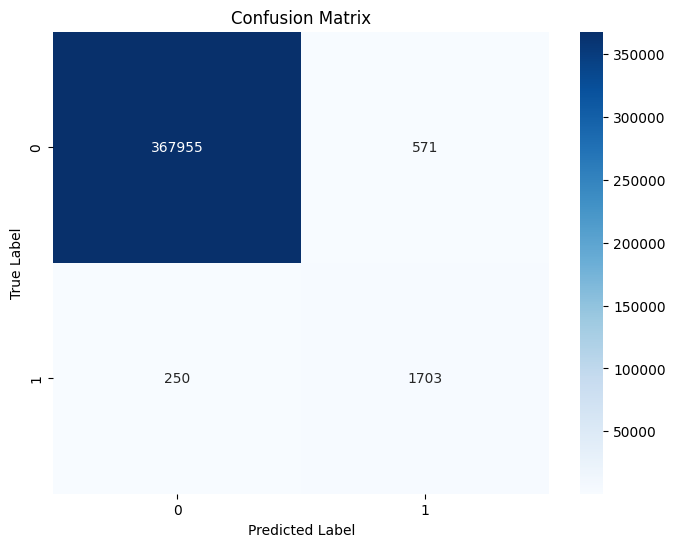

In [26]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Análisis de la Matriz de Confusión

La matriz de confusión muestra el rendimiento detallado del modelo:

- Verdaderos Negativos (367955): Transacciones legítimas que el modelo clasificó correctamente como no fraudulentas
- Falsos Positivos (571): Transacciones legítimas que el modelo clasificó incorrectamente como fraudulentas
- Falsos Negativos (250): Transacciones fraudulentas que el modelo no logró detectar
- Verdaderos Positivos (1703): Transacciones fraudulentas que el modelo identificó correctamente
  Observaciones importantes:
- El modelo demuestra una excelente capacidad para identificar transacciones legítimas, con 367,955 casos correctamente clasificados
- Los falsos positivos (571) representan un número relativamente bajo, lo que significa que pocas transacciones legítimas son bloqueadas innecesariamente
- El número de falsos negativos (250) es menor que los verdaderos positivos (1703), indicando una buena capacidad de detección de fraude
- La diagonal principal (367955 y 1703) refleja un rendimiento sólido en ambas categorías
  En conclusión, la matriz de confusión revela un modelo robusto con un equilibrio favorable entre la detección de fraude y la minimización de falsos positivos, protegiendo tanto los intereses del banco como la experiencia del cliente.


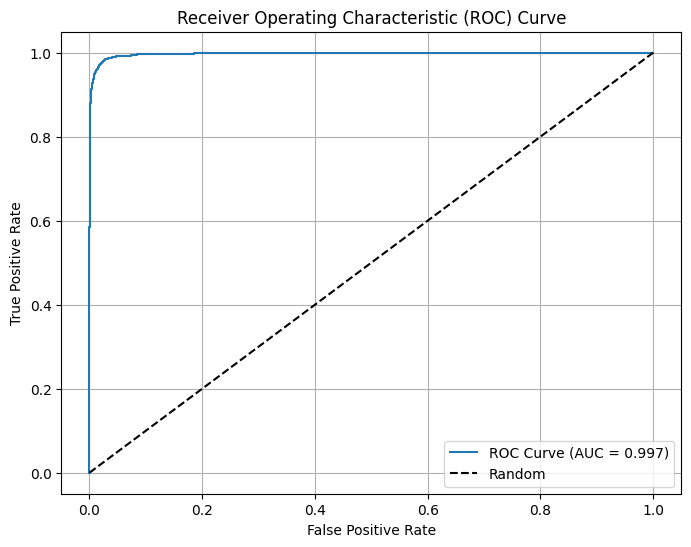

In [28]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()


### Análisis de la Curva ROC

La curva ROC (Receiver Operating Characteristic) mostrada en la gráfica representa el desempeño de nuestro modelo de clasificación para la detección de fraudes. Puntos destacados del análisis:

- El área bajo la curva (AUC) alcanza un valor de 0.997, lo que indica un rendimiento casi perfecto del modelo
- La curva muestra una pendiente casi vertical en el origen, alcanzando rápidamente una tasa de verdaderos positivos cercana a 1.0 con una tasa mínima de falsos positivos
- Existe una separación muy marcada entre la curva de rendimiento del modelo (en azul) y la línea base de clasificación aleatoria (línea punteada)
- La forma de la curva demuestra que el modelo logra una excelente discriminación entre transacciones fraudulentas y legítimas
- El modelo mantiene un rendimiento óptimo y estable a lo largo de diferentes umbrales de decisión
- La curva alcanza el punto (0,1) del espacio ROC de manera muy eficiente, lo que confirma su alta precisión
  En conclusión, la curva ROC evidencia que nuestro modelo posee una capacidad predictiva excepcional para la detección de fraudes en transacciones financieras, con un AUC de 0.997 que lo sitúa muy cerca del clasificador ideal.
